In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = get_device()

Using GPU: NVIDIA GeForce RTX 4090


# Find Game Paths

In [3]:
from npz_loader import discover_games

game_paths = discover_games(Path("dataset/"))
print("\n".join(str(p) for p in game_paths))

dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4
dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4
dataset\EnduroNoFrameskip-v4\EnduroNoFrameskip-v4
dataset\MsPacmanNoFrameskip-v4\MsPacmanNoFrameskip-v4
dataset\PongNoFrameskip-v4\PongNoFrameskip-v4
dataset\QbertNoFrameskip-v4\QbertNoFrameskip-v4
dataset\SeaquestNoFrameskip-v4\SeaquestNoFrameskip-v4
dataset\SpaceInvadersNoFrameskip-v4\SpaceInvadersNoFrameskip-v4


# Load NPZ Files in to Dict

In [4]:
from npz_loader import discover_game_npz_paths, get_sequences_by_game, fix_obs_paths
from pprint import pprint

train_game_dirs = [
    Path(r"dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4"),
    Path(r"dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4"),
]

npz_paths_by_game = discover_game_npz_paths(train_game_dirs)
game_to_sequences = get_sequences_by_game(npz_paths_by_game)
sequences_by_game = fix_obs_paths(game_to_sequences, dataset_root="dataset")

print(f"Loaded games:")
for game in sequences_by_game.keys():
    print(f"\t{game}")
    print(f"\t\tNumber of sequences: {len(sequences_by_game[game])}")

one_game_key = list(sequences_by_game.keys())[0]
one_game_seq_list = sequences_by_game[one_game_key]
one_game_seq = one_game_seq_list[0]

print(f"Keys in one_game_seq ({type(one_game_seq)}):")

one_row = []
for key in one_game_seq.keys():
    arr = one_game_seq[key]
    print(f"\t{key}:")
    print(f"\t\tshape={arr.shape}")
    print(f"\t\tdtype={arr.dtype}")

    row_to_print = 10
    if len(one_game_seq[key]) > 1:
        one_row.append(f"{key}: {one_game_seq[key][row_to_print]}")
    else:
        one_row.append(f"{key}: {one_game_seq[key][0]}")

Loaded games:
	dataset\BeamRiderNoFrameskip-v4\BeamRiderNoFrameskip-v4
		Number of sequences: 200
	dataset\BreakoutNoFrameskip-v4\BreakoutNoFrameskip-v4
		Number of sequences: 200
Keys in one_game_seq (<class 'dict'>):
	model selected actions:
		shape=(548, 1)
		dtype=int64
	taken actions:
		shape=(548, 1)
		dtype=int64
	obs:
		shape=(548,)
		dtype=<U193
	rewards:
		shape=(548,)
		dtype=float64
	episode_returns:
		shape=(1,)
		dtype=float64
	episode_starts:
		shape=(548,)
		dtype=bool
	repeated:
		shape=(548,)
		dtype=bool


# Test Dataset

In [5]:
from atari_dataset import AtariDataset

atari_dataset = AtariDataset(sequences_by_game, context_len=200)

for i in range(0, 1):
    print("-" * 100)
    frames, actions, rtg = atari_dataset[i]

    print("=== Frames (images) ===")
    print(f"frames shape: {frames.shape}")  # (T, C, H, W)
    print(f"frames min/max: {frames.min().item():.4f} / {frames.max().item():.4f}")

    print("\n=== Action Sequence ===")
    print(actions.tolist())

    print("\n=== RTG ===")
    print(rtg)

----------------------------------------------------------------------------------------------------
=== Frames (images) ===
frames shape: torch.Size([200, 1, 84, 84])
frames min/max: 0.0000 / 0.9255

=== Action Sequence ===
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7, 8, 7, 7, 8, 8, 7, 8, 7, 8, 7, 8, 7, 7, 8, 8, 2, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 8, 8, 1, 7, 7, 8, 8, 8, 7, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 2, 1, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 1, 1, 7, 7, 1, 7, 7, 7, 8, 8, 8, 8, 1, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

=== RTG ===
tensor([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
        7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
 

# Test Dataloader

In [6]:
from torch.utils.data import DataLoader
from baseline_train import collate_fn

from atari_dataset import AtariDataset

# -------------------------------
# 1. Build dataset and dataloader
# -------------------------------
context_len = 32  # or whatever you want for testing

dataset = AtariDataset(sequences_by_game, context_len=context_len)
print("dataset length:", len(dataset))

if len(dataset) == 0:
    raise RuntimeError("Dataset is empty — check sequences_by_game and context_len.")

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn,  # Use the collate_fn from baseline_train
)

# -------------------------------
# 2. Get a single batch
# -------------------------------
frames_batch, actions_batch, rtg_batch = next(iter(loader))

print("\n=== Frames batch ===")
print("frames_batch shape:", frames_batch.shape)  # (B, T, C, H, W)
print("frames_batch min/max:", frames_batch.min().item(), frames_batch.max().item())

print("\n=== Actions / RTG shapes ===")
print("actions_batch shape:", actions_batch.shape)  # (B, T)
print("rtg_batch shape:", rtg_batch.shape)  # (B, T)

print("\nFirst few actions of first seq:", actions_batch[0][:10].tolist())
print("First few RTG of first seq:", rtg_batch[0][:10])


dataset length: 160587

=== Frames batch ===
frames_batch shape: torch.Size([2, 32, 1, 84, 84])
frames_batch min/max: 0.0 0.9254902005195618

=== Actions / RTG shapes ===
actions_batch shape: torch.Size([2, 32])
rtg_batch shape: torch.Size([2, 32])

First few actions of first seq: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
First few RTG of first seq: tensor([7., 7., 7., 7., 7., 7., 7., 7., 7., 7.])


# Test Tokenizer

In [7]:
import torch

from baseline_encoder import AtariPatchEncoder
from tokenizer import MGDTTokenizer

# ------------------------------------------------
# 1. Prepare batch tensors from DataLoader output
# ------------------------------------------------
# frames_batch, actions_batch, rtg_batch already from DataLoader:
#   frames_batch: (B, T, C, H, W) - already loaded images
#   actions_batch: (B, T)
#   rtg_batch: (B, T)

B, T = actions_batch.shape

# Frames are already stacked, just use them directly
frames = frames_batch  # (B, T, C, H, W)

print("frames shape:", frames.shape)
print("actions_batch shape:", actions_batch.shape)
print("rtg_batch shape:", rtg_batch.shape)

# ------------------------------------------------
# 2. Initialize patch encoder + tokenizer
# ------------------------------------------------
n_actions = dataset.n_actions()  # from AtariDataset

patch_encoder = AtariPatchEncoder(
    img_size=84,
    patch_size=14,
    in_channels=1,
    d_model=128,   # choose a manageable model size for now
)

tokenizer = MGDTTokenizer(
    patch_encoder=patch_encoder,
    n_actions=n_actions,
    n_games=1,      # single-game for now (BeamRider)
    rtg_min=-20,
    rtg_max=100,
)

# ------------------------------------------------
# 3. Run tokenizer
# ------------------------------------------------
game_ids = torch.zeros(B, dtype=torch.long)  # all BeamRider -> game 0

tok_out = tokenizer(
    frames=frames,                # (B,T,1,84,84)
    actions=actions_batch,        # (B,T)
    rtg=rtg_batch,                # (B,T)
    game_ids=game_ids,            # (B,) or (B,T)
)

tokens = tok_out.tokens

print("\n=== Tokenizer output ===")
print("tokens shape:", tokens.shape)
print("B, T:", tok_out.B, tok_out.T)
print("num_patches:", tok_out.num_patches)
print("tokens_per_step:", tok_out.tokens_per_step)
print("sequence length L:", tokens.shape[1])


frames shape: torch.Size([2, 32, 1, 84, 84])
actions_batch shape: torch.Size([2, 32])
rtg_batch shape: torch.Size([2, 32])

=== Tokenizer output ===
tokens shape: torch.Size([2, 1248, 128])
B, T: 2 32
num_patches: 36
tokens_per_step: 39
sequence length L: 1248


# Test One Step

In [8]:
import torch
from baseline_model import MultiGameDecisionTransformer

tokens = tok_out.tokens           # (B, L, d_model)
B, L, D = tokens.shape
T = tok_out.T
S = tok_out.tokens_per_step
n_actions = dataset.n_actions()

print("Transformer input tokens shape:", tokens.shape)
print("T:", T, "tokens_per_step:", S, "L:", L)

model = MultiGameDecisionTransformer(
    d_model=D,
    n_actions=n_actions,
    n_layers=2,          # keep small for now
    n_heads=4,
    dim_feedforward=4 * D,
    dropout=0.1,
    max_seq_len=2048,
)

out = model(tokens, tokens_per_step=S, T=T)

print("\n=== MGDT model output ===")
print("logits shape:", out.logits.shape)         # expect (B, T, n_actions)
print("hidden shape:", out.hidden.shape)         # (B, L, D)
print("action_positions shape:", out.action_positions.shape)
print("first action_positions row:", out.action_positions[0])


Transformer input tokens shape: torch.Size([2, 1248, 128])
T: 32 tokens_per_step: 39 L: 1248


c:\Users\idanc\local\projects\AtariDeepLearning\.venv_atari\Lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



=== MGDT model output ===
logits shape: torch.Size([2, 32, 9])
hidden shape: torch.Size([2, 1248, 128])
action_positions shape: torch.Size([2, 32])
first action_positions row: tensor([  38,   77,  116,  155,  194,  233,  272,  311,  350,  389,  428,  467,
         506,  545,  584,  623,  662,  701,  740,  779,  818,  857,  896,  935,
         974, 1013, 1052, 1091, 1130, 1169, 1208, 1247])


# Train

In [1]:
from baseline_train import train, create_train_test_dataloaders
from baseline_encoder import AtariPatchEncoder
from tokenizer import MGDTTokenizer
from baseline_model import MultiGameDecisionTransformer
from atari_dataset import AtariDataset

# Configuration
context_len = 32
batch_size = 32
d_model = 128
n_games = 1
train_fraction = 0.8

# Create train and test dataloaders
train_loader, test_loader = create_train_test_dataloaders(
    sequences_by_game,
    total_frac=0.5,
    train_fraction=train_fraction,
    context_len=context_len,
    batch_size=batch_size,
    num_workers=16,
    seed=42,
)

# Get n_actions from dataset
n_actions = train_loader.dataset.n_actions()
print(f"Number of actions: {n_actions}")

# Create patch encoder
patch_encoder = AtariPatchEncoder(
    img_size=84,
    patch_size=14,
    in_channels=1,
    d_model=d_model,
)

# Create tokenizer
tokenizer = MGDTTokenizer(
    patch_encoder=patch_encoder,
    n_actions=n_actions,
    n_games=n_games,
    rtg_min=-20,
    rtg_max=100,
)

# # Create model
# model = MultiGameDecisionTransformer(
#     d_model=d_model,
#     n_actions=n_actions,
#     n_layers=2,
#     n_heads=4,
#     dim_feedforward=4 * d_model,
#     dropout=0.1,
#     max_seq_len=2048,
# )

# # Train the model
# trained_model, train_losses, val_losses = train(
#     model=model,
#     tokenizer=tokenizer,
#     train_loader=train_loader,
#     test_loader=test_loader,
#     num_epochs=1,
#     learning_rate=1e-4,
#     n_games=n_games,
#     eval_every_n_epochs=1,
# )



NameError: name 'sequences_by_game' is not defined

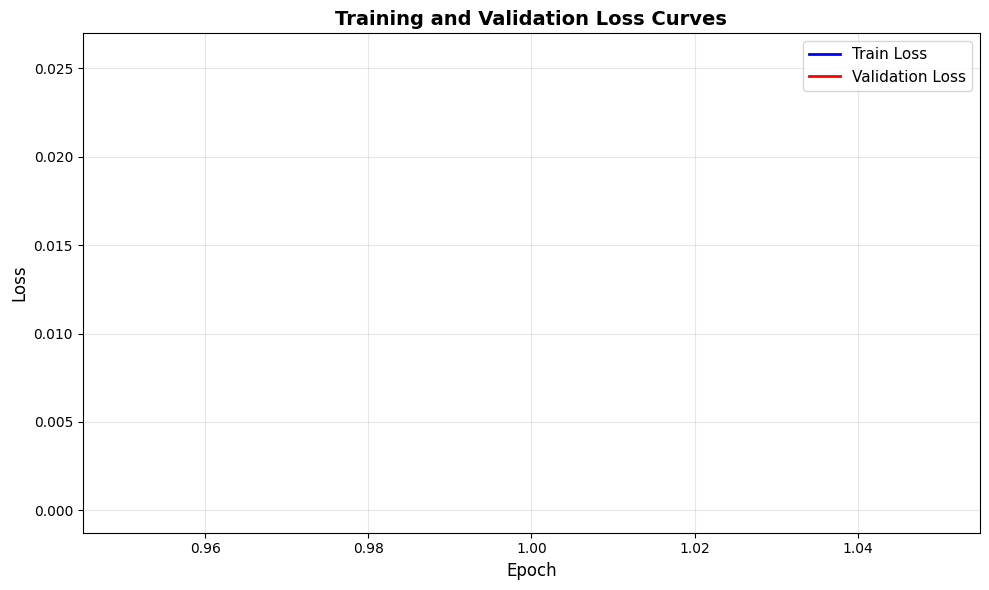

Final train loss: 0.0257
Final validation loss: 0.0000


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Plot train vs validation loss curves
# epochs = range(1, len(train_losses) + 1)

# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)

# # Filter out None values for validation losses
# val_epochs = [e for e, v in zip(epochs, val_losses) if v is not None]
# val_losses_filtered = [v for v in val_losses if v is not None]

# if val_losses_filtered:
#     plt.plot(val_epochs, val_losses_filtered, 'r-', label='Validation Loss', linewidth=2)

# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Loss', fontsize=12)
# plt.title('Training and Validation Loss Curves', fontsize=14, fontweight='bold')
# plt.legend(fontsize=11)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

# # Print final losses
# print(f"Final train loss: {train_losses[-1]:.4f}")
# if val_losses_filtered:
#     print(f"Final validation loss: {val_losses_filtered[-1]:.4f}")


In [ ]:
from diagnostics import generate_diagnostics

# Generate comprehensive diagnostics
stats = generate_diagnostics(
    train_loader=train_loader,
    test_loader=test_loader,
    tokenizer=tokenizer,
    device=device,
    max_samples=500,  # Limit for quick diagnostics
    save_dir="diagnostics",
    show_plots=True,
)

# Print key validation results
print("\n=== Tokenization Verification ===")
print(f"All checks passed: {stats['tokenization']['all_checks_passed']}")
print(f"  - Tokens per step valid: {stats['tokenization']['tokens_per_step_valid']}")
print(f"  - Sequence length valid: {stats['tokenization']['seq_len_valid']}")
print(f"  - Action tokens match: {stats['tokenization']['action_tokens_match']}")
print(f"  - RTG IDs valid: {stats['tokenization']['rtg_ids_valid']}")

print("\n=== Data Consistency ===")
print(f"All consistent: {stats['consistency']['all_consistent']}")
print(f"  - Train batch/seq match: {stats['consistency']['checks']['train']['batch_match']}, {stats['consistency']['checks']['train']['seq_match']}")
print(f"  - Test batch/seq match: {stats['consistency']['checks']['test']['batch_match']}, {stats['consistency']['checks']['test']['seq_match']}")

print("\n=== Action Distribution ===")
print(f"Train actions valid: {stats['action']['train_valid']} (range: {stats['action']['train_min']}-{stats['action']['train_max']}, unique: {stats['action']['train_unique']})")
print(f"Test actions valid: {stats['action']['test_valid']} (range: {stats['action']['test_min']}-{stats['action']['test_max']}, unique: {stats['action']['test_unique']})")

print("\n=== Image Encoding ===")
print(f"Train normalized: {stats['image']['train_normalized']} (pixel range: [{stats['image']['train_pixel_min']:.3f}, {stats['image']['train_pixel_max']:.3f}])")
print(f"Test normalized: {stats['image']['test_normalized']} (pixel range: [{stats['image']['test_pixel_min']:.3f}, {stats['image']['test_pixel_max']:.3f}])")

print("\n=== RTG Distribution ===")
print(f"Train RTG range: [{stats['rtg']['train_min']:.2f}, {stats['rtg']['train_max']:.2f}], mean: {stats['rtg']['train_mean']:.2f}")
print(f"Train RTG clipped: {stats['rtg']['train_clipped']} ({stats['rtg']['train_clip_pct']:.2f}%)")
print(f"Train RTG bins used: {stats['rtg']['train_bins_used']}/{stats['rtg']['n_rtg_bins']}")


KeyboardInterrupt: 

In [11]:
# TODO